<a href="https://colab.research.google.com/github/ucfilho/ANN/blob/master/ANN_2022/Image_07/class_007_image_processing_blood_cells_003.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
tf.__version__

'2.9.2'

In [2]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, BatchNormalization, ZeroPadding2D, MaxPool2D, Activation, add
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

import cv2

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from glob import glob

import zipfile
import pandas as pd


from sklearn.metrics import classification_report, confusion_matrix

In [3]:
IMAGE_SIZE = [224,224]
ImgSize = IMAGE_SIZE[0]
epochs = 16
batch_size = 128

In [4]:
!gdown 1CU4UkqJae07u1tKfp2rajWwwZA0SKiIm

Downloading...
From: https://drive.google.com/uc?id=1CU4UkqJae07u1tKfp2rajWwwZA0SKiIm
To: /content/blood_cell_images.zip
100% 110M/110M [00:00<00:00, 229MB/s] 


In [5]:
FILE='blood_cell_images.zip'

In [6]:
archive = zipfile.ZipFile(FILE, 'r')
archive.extractall()

In [7]:
!ls

blood_cell_images  blood_cell_images.zip  __MACOSX  sample_data


In [8]:
train_path = 'blood_cell_images/TRAIN'
test_path = 'blood_cell_images/TEST'
images_test = glob(test_path + '/*/*.jp*g')
images_train = glob(train_path + '/*/*.jp*g')

In [9]:
folders_train = glob(train_path + '/*')
folders_test = glob(test_path + '/*')

In [10]:
folders_train

['blood_cell_images/TRAIN/LYMPHOCYTE',
 'blood_cell_images/TRAIN/MONOCYTE',
 'blood_cell_images/TRAIN/NEUTROPHIL',
 'blood_cell_images/TRAIN/EOSINOPHIL']

In [11]:
folders_test

['blood_cell_images/TEST/LYMPHOCYTE',
 'blood_cell_images/TEST/MONOCYTE',
 'blood_cell_images/TEST/NEUTROPHIL',
 'blood_cell_images/TEST/EOSINOPHIL']

In [12]:
ntrain, ntest = len(images_train),len(images_test)
ntrain,ntest

(9957, 2487)

In [13]:
images_train[:4]

['blood_cell_images/TRAIN/LYMPHOCYTE/_18_6064.jpeg',
 'blood_cell_images/TRAIN/LYMPHOCYTE/_14_2074.jpeg',
 'blood_cell_images/TRAIN/LYMPHOCYTE/_0_6532.jpeg',
 'blood_cell_images/TRAIN/LYMPHOCYTE/_22_1298.jpeg']

In [14]:
types = ['NEUTROPHIL', 'EOSINOPHIL', 'MONOCYTE', 'LYMPHOCYTE']

In [15]:
def load_images(images,types=types):

  nsize = len(images)
  X =[]
  y =[]
  names =[]

  for i in range(nsize): 
    img = image.load_img(images[i])
    im = cv2.resize(np.array(img), (224, 224))
    
    X.append(im)

    if(types[0] in images[i]):
      names.append(types[0])
      y.append(0)
    elif(types[1] in images[i]):
      names.append(types[1])
      y.append(1)
    elif(types[2] in images[i]):
      names.append(types[2])
      y.append(2)
    else:
      names.append(types[3])
      y.append(3)

  return X,y,names

In [16]:

X_train, y_train, names_train = load_images(images_train)
X_test, y_test, names_test = load_images(images_test)

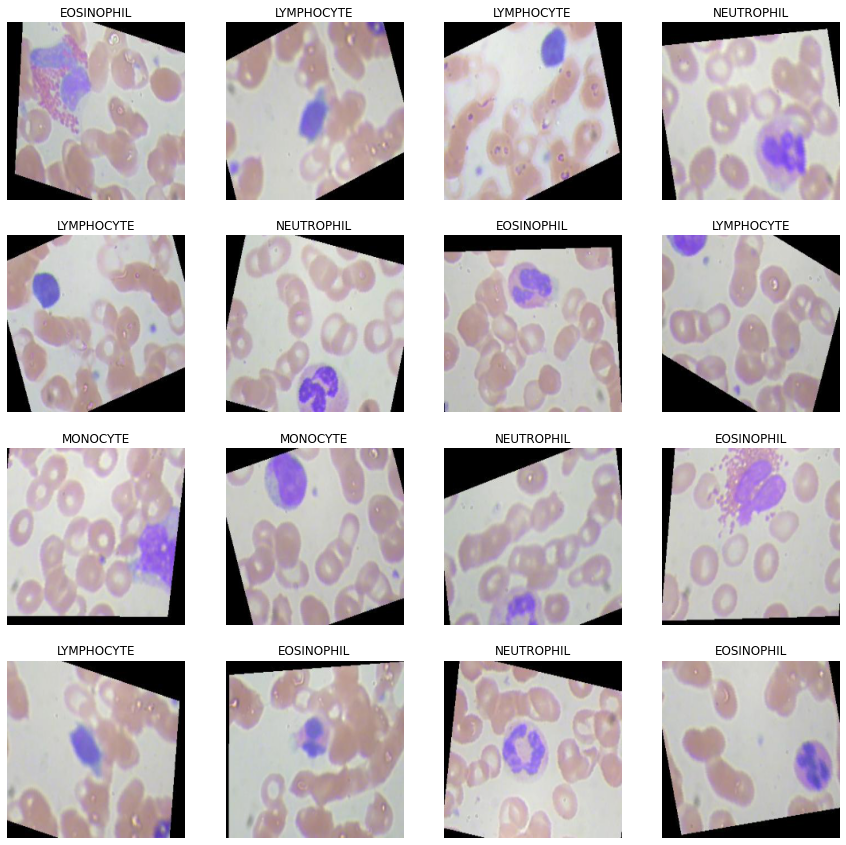

In [17]:
plt.figure(figsize=(15, 15))

for i in range(16): 
  ax = plt.subplot(4, 4, i + 1)
  k = int(np.random.choice(range(ntrain)))
  plt.imshow(X_train[k])
  plt.title(names_train[k])
  plt.axis("off")

In [18]:
X_train[0].shape

(224, 224, 3)

In [19]:
df = pd.DataFrame({'name':names_train,'class':y_train})
y_train = pd.get_dummies(df['class'])
y_train

,0,1,2,3
0,0,0,0,1
1,0,0,0,1
2,0,0,0,1
3,0,0,0,1
4,0,0,0,1
...,...,...,...,...
9952,0,1,0,0
9953,0,1,0,0
9954,0,1,0,0
9955,0,1,0,0


In [20]:
for i in range(4): 
  df_plot= df[(df["class"] == i)]
  n= df_plot.shape[0]
  print(types[i],n)

NEUTROPHIL 2499
EOSINOPHIL 2497
MONOCYTE 2478
LYMPHOCYTE 2483


In [21]:
df = pd.DataFrame({'name':names_test,'class':y_test})
y_test = pd.get_dummies(df['class'])
y_test

,0,1,2,3
0,0,0,0,1
1,0,0,0,1
2,0,0,0,1
3,0,0,0,1
4,0,0,0,1
...,...,...,...,...
2482,0,1,0,0
2483,0,1,0,0
2484,0,1,0,0
2485,0,1,0,0


In [22]:
X_train = np.array(X_train)
X_test = np.array(X_test)
#X_train = X_train.reshape(-1, ImgSize, ImgSize, 3) / 255.0
#X_test = X_test.reshape(-1, ImgSize, ImgSize, 3) / 255.0

In [23]:
from tensorflow.keras.applications import vgg16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,  Flatten, Dropout
# Init the VGG model 
vgg_conv = vgg16.VGG16(weights='imagenet') #, include_top=False, input_shape=(Img_Size, Img_Size, 3))

# Freeze all the layers
for layer in vgg_conv.layers[:]:
    layer.trainable = False

# Create the model
model = Sequential()
 
# Add the vgg convolutional base model
model.add(vgg_conv)
D = len(types)
# Add new layers
model.add(Flatten())
model.add(Dense(300, activation='relu')) #relu
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu')) #relu
model.add(Dropout(0.2))
model.add(Dense(D, activation= 'softmax'))#'relu'))

In [24]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [25]:
r = model.fit(X_train, y_train, epochs=20)
print("Returned:", r)

Epoch 1/20
312/312 [==============================] - 57s 166ms/step - loss: 1.3449 - accuracy: 0.3388
Epoch 2/20
312/312 [==============================] - 51s 163ms/step - loss: 1.2670 - accuracy: 0.4100
Epoch 3/20
312/312 [==============================] - 51s 163ms/step - loss: 1.2106 - accuracy: 0.4544
Epoch 4/20
312/312 [==============================] - 51s 162ms/step - loss: 1.1635 - accuracy: 0.4790
Epoch 5/20
312/312 [==============================] - 51s 162ms/step - loss: 1.1241 - accuracy: 0.5018
Epoch 6/20
312/312 [==============================] - 51s 162ms/step - loss: 1.0891 - accuracy: 0.5244
Epoch 7/20
312/312 [==============================] - 51s 163ms/step - loss: 1.0516 - accuracy: 0.5443
Epoch 8/20
312/312 [==============================] - 51s 163ms/step - loss: 1.0315 - accuracy: 0.5511
Epoch 9/20
312/312 [==============================] - 51s 162ms/step - loss: 1.0020 - accuracy: 0.5657
Epoch 10/20
312/312 [==============================] - 51s 162ms/step - l

In [26]:
'''
r = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    verbose=2
)'''

'\nr = model.fit(\n    x=X_train,\n    y=y_train,\n    validation_data=(X_test, y_test),\n    epochs=30,\n    verbose=2\n)'

In [27]:
def retorna(y):
  resp = []
  for yi in y:
    vmax =max(yi)
    for idx, x in enumerate(yi):
      if(x == vmax):
        resp.append(idx)
  return resp

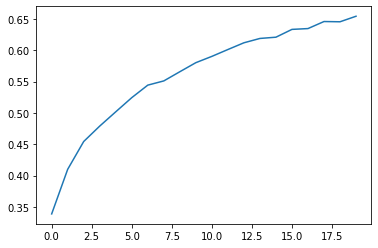

In [28]:
plt.plot(r.history['accuracy'],label='accuracy')
#plt.plot(r.history['val_accuracy'],label='val_accuracy')
#plt.legend()

In [29]:
predict=model.predict(X_test)

78/78 [==============================] - 15s 192ms/step


In [30]:
y_calc = retorna(predict)
y_test = retorna(np.array(y_test))

In [31]:
confusion_matrix(y_test, y_calc)

array([[315, 180,  43,  86],
       [236, 219,  50, 118],
       [193, 315,  55,  57],
       [200, 172,  55, 193]])

In [32]:
# Classification Report
print('\n\n', classification_report(y_test, y_calc, target_names=types))



               precision    recall  f1-score   support

  NEUTROPHIL       0.33      0.50      0.40       624
  EOSINOPHIL       0.25      0.35      0.29       623
    MONOCYTE       0.27      0.09      0.13       620
  LYMPHOCYTE       0.43      0.31      0.36       620

    accuracy                           0.31      2487
   macro avg       0.32      0.31      0.30      2487
weighted avg       0.32      0.31      0.30      2487

